In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs
subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()
from scipy import interpolate
plt.style.use('default')

def get_mcflirt_motion_params(motion_params_fname, use_mm_deg = False):
    motion_params = np.genfromtxt(motion_params_fname)
    rotations = motion_params[:, :3] # in radians
    translations = motion_params[:, 3:6] # in mm
    if use_mm_deg:
        rotations = np.rad2deg(rotations)
    motion_params = np.hstack((translations, rotations))
    return motion_params

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']


all_data = pickle.load(open('../../data/all_data_list.pkl', 'rb'))


In [2]:
from sklearn.linear_model import LinearRegression
from numpy.polynomial.legendre import Legendre
from mocet import utils
from mocet import simulation
import warnings

def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 1))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X


def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data

data_keys = []
cross_alignment_errors = []
within_errors = []
polynomial_errors = []
uncorrected_errors = []

unusable_data_errors = []
usable_data_errors = []
subjects = subject_pool.keys()
for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        print(subject, session)
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        motion_params_root = '../../data/cross_alignment/merged_motion_params'
        merged_motion_params_fname = f'{motion_params_root}/{subject}_{session}_task-mcHERDING_run-merged_bold_mcf.par'

        if len(runs) >= 2 and os.path.exists(merged_motion_params_fname):
            calibration_errors = []
            for r in runs:
                run = f'run-{r}'
                key = (subject, session, task, run)
                calibration_error, _ = all_data[key]
                if calibration_error == None:
                    calibration_error = 99.99
                calibration_errors.append(calibration_error)
            min_error_idx = np.argmin(calibration_errors)
            print('best calibration run:', runs[min_error_idx])
            best_run = f'run-{runs[min_error_idx]}'
            data_keys.append((subject, session, best_run, calibration_errors[min_error_idx]))

            run_pupils = {}
            run_motion_params = {}
            run_pupil_timestamps = {}
            run_pupil_confidences = {}

            concatenate_pupils = []
            concatenate_motion_params = []

            motion_params_root = '../../data/cross_alignment/merged_motion_params'
            merged_motion_params_fname = f'{motion_params_root}/{subject}_{session}_task-mcHERDING_run-merged_bold_mcf.par'
            merged_motion_params = get_mcflirt_motion_params(merged_motion_params_fname)

            for r in runs:
                np.random.seed(0)  # for reproducibility

                run = f'run-{r}'
                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                # log, data, confound, start
                pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
                    log_fname,
                    data_fname,
                    start=start,
                    duration=task_duration)
                if pupil_timestamps[-1] > ((task_duration - 1)) * 1000:  # valid run
                    concatenate_pupils.append(pupil_data)

                    motion_params = np.copy(merged_motion_params[510 * (r - 1):510 * r, :])

                    motion_params_resample = np.zeros((len(pupil_data), motion_params.shape[1]))
                    x = np.arange(0, len(motion_params))
                    for i in range(motion_params.shape[1]):
                        y = motion_params[:, i]
                        f = interpolate.interp1d(x, y)
                        xnew = np.linspace(0, len(motion_params) - 1, len(pupil_data))
                        motion_params_resample[:, i] = f(xnew)
                    concatenate_motion_params.append(motion_params_resample)

                    run = f'run-{r}'
                    run_pupils[run] = pupil_data
                    run_pupil_timestamps[run] = pupil_timestamps
                    run_pupil_confidences[run] = pupil_confidence
                    run_motion_params[run] = motion_params_resample

            concatenate_pupils = np.vstack(concatenate_pupils)
            concatenate_motion_params = np.vstack(concatenate_motion_params)

            # fitting with best run
            motion_params =run_motion_params[best_run]
            pupil_data = run_pupils[best_run]
            pupil_timestamps = run_pupil_timestamps[best_run]
            pupil_confidence = run_pupil_confidences[best_run]

            X = np.hstack((run_motion_params[best_run], make_poly_regressors(len(motion_params), order=3)))

            coefs_ = []
            models = []
            dedrift_regressor = np.zeros((len(pupil_data), 2))
            for i in range(2):
                reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
                coefs_.append(reg.coef_)
                models.append(reg)
                dedrift_regressor[:, i] = reg.predict(X)
            pupils_corrected = pupil_data[:, :2] - dedrift_regressor
            pupils_corrected_mean = np.mean(pupils_corrected, axis=0)

            offset = calibration_onsets[0]
            calibration_pupils = []
            for i in np.arange(calibration_points[0]):
                start = (offset+i)*interval + calibration_offset_start
                end = (offset+i+1)*interval + calibration_offset_end
                log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                calibration_pupils.append([np.nanmean(pupils_corrected[log_effective,0]),
                                          np.nanmean(pupils_corrected[log_effective,1])])
            calibration_pupils = np.array(calibration_pupils)

            calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                      calibration_order = calibration_order,
                                                      repeat=True)
            calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])

            # test with using other runs
            session_error = []
            for r in runs:
                test_run = f'run-{r}'
                key = (subject, session, task, test_run)
                calibration_error, validation_error = all_data[key]
                if validation_error != None:
                    if np.all([validation_error <= 1.0, test_run != best_run]):
                        motion_params = run_motion_params[test_run]
                        pupil_data = run_pupils[test_run]
                        pupil_timestamps = run_pupil_timestamps[test_run]
                        pupil_confidence = run_pupil_confidences[test_run]

                        X = motion_params
                        dedrift_regressor = np.zeros((len(pupil_data), 2))
                        for i in range(2):
                            dedrift_regressor[:, i] = X @ coefs_[i][:6]
                        pupils_corrected = pupil_data[:, :2] - dedrift_regressor
                        pupils_corrected = polynomial_detrending(pupils_corrected, polynomial_order=3)
                        gaze_coordinates = calibrator.transform(pupils_corrected)

                        MSE = []
                        offset = calibration_onsets[1]
                        for i in np.arange(calibration_points[1]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset + i) * interval + calibration_offset_start
                            end = (offset + i + 1) * interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        validation_error = np.nanmean(MSE) / px_per_deg
                        session_error.append(validation_error)
                        if calibration_error >= 1.0:
                            unusable_data_errors.append(validation_error)
                        else:
                            usable_data_errors.append(validation_error)
            session_error = np.mean(session_error)
            print('Session across-map validation error:', session_error)
            cross_alignment_errors.append(session_error)

            # without cross-alignment calibration error (polynomial)
            session_error = []
            for r in runs:
                test_run = f'run-{r}'
                key = (subject, session, task, test_run)
                calibration_error, validation_error = all_data[key]
                if validation_error != None:
                    if np.all([validation_error <= 1.0, test_run != best_run]):
                        motion_params = run_motion_params[test_run]
                        pupil_data = run_pupils[test_run]
                        pupil_timestamps = run_pupil_timestamps[test_run]
                        pupil_confidence = run_pupil_confidences[test_run]

                        pupils_corrected = polynomial_detrending(pupil_data, polynomial_order=3)
                        gaze_coordinates = calibrator.transform(pupils_corrected) # without mocet

                        MSE = []
                        offset = calibration_onsets[1]
                        for i in np.arange(calibration_points[1]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset + i) * interval + calibration_offset_start
                            end = (offset + i + 1) * interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        validation_error = np.nanmean(MSE) / px_per_deg
                        session_error.append(validation_error)
            session_error = np.mean(session_error)
            print('Session without cross-mocet alignment validation error (polynomial):', session_error)
            polynomial_errors.append(session_error)

            # without cross-alignment calibration error (de-mean)
            session_error = []
            for r in runs:
                test_run = f'run-{r}'
                key = (subject, session, task, test_run)
                calibration_error, validation_error = all_data[key]
                if validation_error != None:
                    if np.all([validation_error <= 1.0, test_run != best_run]):
                        motion_params = run_motion_params[test_run]
                        pupil_data = run_pupils[test_run]
                        pupil_timestamps = run_pupil_timestamps[test_run]
                        pupil_confidence = run_pupil_confidences[test_run]

                        pupil_data -= np.mean(pupil_data[:60, :], axis=0) #Recenter the pupil (based on the first 1s)
                        pupils_corrected = pupil_data + pupils_corrected_mean
                        #pupils_corrected = polynomial_detrending(pupil_data, polynomial_order=1)
                        gaze_coordinates = calibrator.transform(pupils_corrected) # without mocet

                        MSE = []
                        offset = calibration_onsets[1]
                        for i in np.arange(calibration_points[1]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset + i) * interval + calibration_offset_start
                            end = (offset + i + 1) * interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        validation_error = np.nanmean(MSE) / px_per_deg
                        session_error.append(validation_error)
            session_error = np.mean(session_error)
            print('Session without cross-mocet alignment validation error (re-centering):', session_error)
            uncorrected_errors.append(session_error)

            # within_run calibration error
            session_error = []
            for r in runs:
                test_run = f'run-{r}'
                key = (subject, session, task, test_run)
                calibration_error, validation_error = all_data[key]
                if validation_error != None:
                    if np.all([validation_error <= 1.0, test_run != best_run]):
                        motion_params = run_motion_params[test_run]
                        pupil_data = run_pupils[test_run]
                        pupil_timestamps = run_pupil_timestamps[test_run]
                        pupil_confidence = run_pupil_confidences[test_run]

                        X = np.hstack((motion_params, make_poly_regressors(len(motion_params),
                                                                           order=3)))
                        coefs_ = []
                        models = []
                        dedrift_regressor = np.zeros((len(pupil_data), 2))
                        for i in range(2):
                            reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
                            coefs_.append(reg.coef_)
                            models.append(reg)
                            dedrift_regressor[:, i] = reg.predict(X)
                        pupils_corrected = pupil_data[:, :2] - dedrift_regressor
                        #pupils_corrected -= np.mean(pupils_corrected, axis=0)

                        offset = calibration_onsets[0]
                        calibration_pupils = []
                        for i in np.arange(calibration_points[0]):
                            start = (offset+i)*interval + calibration_offset_start
                            end = (offset+i+1)*interval + calibration_offset_end
                            log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                            calibration_pupils.append([np.nanmean(pupils_corrected[log_effective,0]),
                                                      np.nanmean(pupils_corrected[log_effective,1])])
                        calibration_pupils = np.array(calibration_pupils)

                        calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                                  calibration_order = calibration_order,
                                                                  repeat=True)
                        calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                        gaze_coordinates = calibrator.transform(pupils_corrected)

                        MSE = []
                        offset = calibration_onsets[1]
                        for i in np.arange(calibration_points[1]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            start = (offset + i) * interval + calibration_offset_start
                            end = (offset + i + 1) * interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        validation_error = np.nanmean(MSE) / px_per_deg
                        session_error.append(validation_error)
            session_error = np.mean(session_error)
            print('Session within-run validation error:', session_error)
            within_errors.append(session_error)

within_errors = np.array(within_errors)
cross_alignment_errors = np.array(cross_alignment_errors)
polynomial_errors = np.array(polynomial_errors)
uncorrected_errors = np.array(uncorrected_errors)

data_keys = [key for k, key in enumerate(data_keys) if not np.isnan(within_errors[k])]
within_errors = within_errors[~np.isnan(within_errors)]
cross_alignment_errors = cross_alignment_errors[~np.isnan(cross_alignment_errors)]
polynomial_errors = polynomial_errors[~np.isnan(polynomial_errors)]
uncorrected_errors = uncorrected_errors[~np.isnan(uncorrected_errors)]

usable_data_errors = np.array(usable_data_errors)
unusable_data_errors = np.array(unusable_data_errors)

sub-003 ses-07R
best calibration run: 4
Session across-map validation error: 2.214307645689935
Session without cross-mocet alignment validation error (polynomial): 3.2153014978677206
Session without cross-mocet alignment validation error (re-centering): 13.452314540675678
Session within-run validation error: 1.1787397874820418
sub-003 ses-13R
best calibration run: 5
Session across-map validation error: 0.8422527501558547
Session without cross-mocet alignment validation error (polynomial): 3.339488477622622
Session without cross-mocet alignment validation error (re-centering): 7.946902159165816
Session within-run validation error: 1.1603098018223166
sub-004 ses-07R
best calibration run: 2
Session across-map validation error: 1.808910836679905
Session without cross-mocet alignment validation error (polynomial): 1.903655387931168
Session without cross-mocet alignment validation error (re-centering): 5.827356309856911
Session within-run validation error: 1.3502455936740287
sub-004 ses-13
b

/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Session across-map validation error: nan
Session without cross-mocet alignment validation error (polynomial): nan
Session without cross-mocet alignment validation error (re-centering): nan
Session within-run validation error: nan
sub-010 ses-07
best calibration run: 1
Session across-map validation error: 1.2706340930900466
Session without cross-mocet alignment validation error (polynomial): 3.812626757047615
Session without cross-mocet alignment validation error (re-centering): 4.573765140318586
Session within-run validation error: 0.8165862799064114
sub-010 ses-13
best calibration run: 6


/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Session across-map validation error: nan
Session without cross-mocet alignment validation error (polynomial): nan
Session without cross-mocet alignment validation error (re-centering): nan
Session within-run validation error: nan
sub-011 ses-07
best calibration run: 2
Session across-map validation error: 1.51991463988301
Session without cross-mocet alignment validation error (polynomial): 5.7113516363819254
Session without cross-mocet alignment validation error (re-centering): 8.566658089156565
Session within-run validation error: 2.162247947619564
sub-011 ses-13
best calibration run: 4
Session across-map validation error: 1.2813557536486104
Session without cross-mocet alignment validation error (polynomial): 2.5647264848267346
Session without cross-mocet alignment validation error (re-centering): 6.628495392148446
Session within-run validation error: 1.3670889767483516
sub-015 ses-07
best calibration run: 1
Session across-map validation error: 1.1126228021933908
Session without cross-

/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jwpark/anaconda3/envs/mocet/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Session across-map validation error: nan
Session without cross-mocet alignment validation error (polynomial): nan
Session without cross-mocet alignment validation error (re-centering): nan
Session within-run validation error: nan
sub-019 ses-07A
best calibration run: 1
Session across-map validation error: 1.279069041753108
Session without cross-mocet alignment validation error (polynomial): 1.999594418000682
Session without cross-mocet alignment validation error (re-centering): 6.306400539116844
Session within-run validation error: 1.8677096137716547
sub-019 ses-13
best calibration run: 1
Session across-map validation error: 3.6883728876053965
Session without cross-mocet alignment validation error (polynomial): 4.094821020896703
Session without cross-mocet alignment validation error (re-centering): 5.80898066828472
Session within-run validation error: 1.0962608904084696
sub-020 ses-07
best calibration run: 5
Session across-map validation error: 1.5482896193378846
Session without cross-

In [6]:
print(np.mean(unusable_data_errors))
print(np.mean(usable_data_errors))

subjects = subject_pool.keys()
for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        motion_params_root = '../../data/cross_alignment/merged_motion_params'
        merged_motion_params_fname = f'{motion_params_root}/{subject}_{session}_task-mcHERDING_run-merged_bold_mcf.par'

        if len(runs) >= 2 and os.path.exists(merged_motion_params_fname):
            calibration_errors = []
            for r in runs:
                run = f'run-{r}'
                key = (subject, session, task, run)
                calibration_error, _ = all_data[key]
                if calibration_error == None:
                    calibration_error = 99.99
                calibration_errors.append(calibration_error)
            min_error_idx = np.argmin(calibration_errors)
            best_run = f'run-{runs[min_error_idx]}'

            for r in runs:
                test_run = f'run-{r}'
                key = (subject, session, task, test_run)
                calibration_error, validation_error = all_data[key]
                if validation_error != None:
                    if np.all([validation_error <= 1.0, test_run != best_run]):
                        if calibration_error > 1.0:
                            print(key, calibration_error, validation_error)

1.8850143309929945
1.745665833156853
('sub-005', 'ses-13', 'task-mcHERDING', 'run-6') 1.0531567237802477 0.2525749509442881
('sub-008', 'ses-13', 'task-mcHERDING', 'run-1') 1.7990947115971383 0.21802538611908628
('sub-009', 'ses-07', 'task-mcHERDING', 'run-1') 1.3172240274113107 0.8006649155336644
('sub-011', 'ses-07', 'task-mcHERDING', 'run-1') 1.752237216558655 0.6865875111891151
('sub-011', 'ses-07', 'task-mcHERDING', 'run-3') 1.1727935297883247 0.8887590752159334
('sub-011', 'ses-07', 'task-mcHERDING', 'run-5') 1.4171622495608878 0.6544228571084568
('sub-011', 'ses-07', 'task-mcHERDING', 'run-6') 1.1789399088188486 0.3805051929602027
('sub-018', 'ses-07', 'task-mcHERDING', 'run-1') 1.13248462479191 0.23596928119670196
('sub-020', 'ses-07', 'task-mcHERDING', 'run-3') 1.3655665457939044 0.19981851085972951
('sub-021', 'ses-07', 'task-mcHERDING', 'run-5') 2.51950296700346 0.7968552863176113
('sub-022', 'ses-13', 'task-mcHERDING', 'run-5') 1.1439610008454417 0.7414548067980942


TtestResult(statistic=np.float64(-0.4350248631172657), pvalue=np.float64(0.6643596787223714), df=np.float64(115.0))


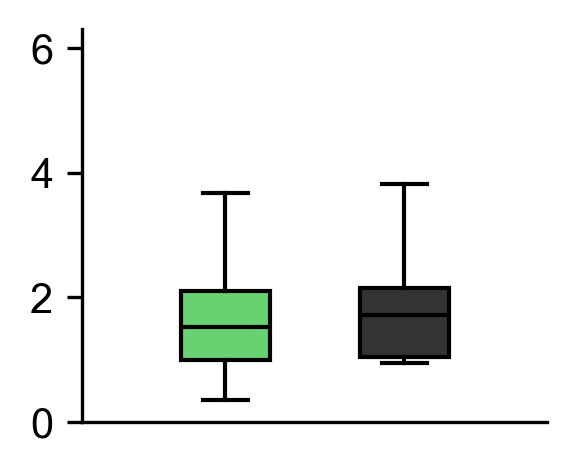

In [21]:
from scipy.stats import ttest_ind

print(ttest_ind(usable_data_errors, unusable_data_errors))
fig, ax = plt.subplots(1, 1, figsize=(2, 1.7), dpi=300)
box = ax.boxplot([usable_data_errors, unusable_data_errors],
                 patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black'),
            positions=[0, 1],
            widths=[0.5, 0.5], )

colors = ['#68d171', '#333333']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 1.8)
ax.set_yticks([0,2,4, 6])
ax.set_ylim(0, 6.3)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

(4, 34)


(0.0, 18.0)

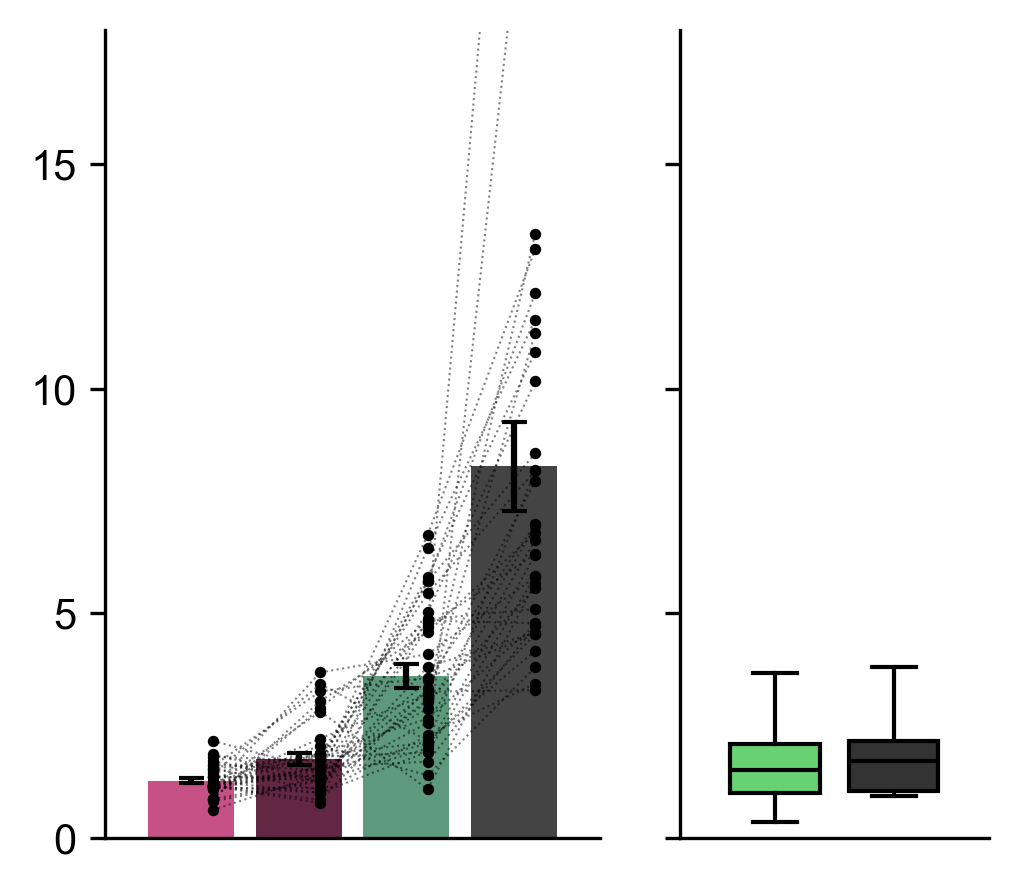

In [33]:

from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

# Define the tags for the errors
tags = ['mocet-within', 'mocet-across', 'polynomial', 'uncorrected']

MSE_matrix = np.concatenate([
    within_errors.reshape(1,-1),
    cross_alignment_errors.reshape(1,-1),
    polynomial_errors.reshape(1,-1),
    uncorrected_errors.reshape(1,-1)
], axis=0)
print(MSE_matrix.shape)

#color_list = ['#c55187', '#c55187','#5e997d']
color_list = ['#c55187', '#622843','#5e997d', '#444444']
hatches = ['', '', '', '']
fig, axes = plt.subplots(1, 2, figsize=(3.8,3.5), dpi=300,  sharey=True,
                         gridspec_kw={"width_ratios": [4,2.5],})

axes[0].bar(np.arange(4),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list, hatch=hatches)

box = axes[1].boxplot([usable_data_errors, unusable_data_errors],
                 patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black'),
            positions=[0,1],
            widths=[0.75, 0.75], )

colors = ['#68d171', '#333333']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# # Add scatter points to the box plot
for i in range(4):
    axes[0].scatter(np.ones(len(within_errors)) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(len(within_errors)):
    for i in range(3):
        axes[0].plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)
for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks([])
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

axes[0].set_xlim(-0.8, 3.8)
axes[1].set_xlim(-0.8, 1.8)
axes[0].set_yticks([0, 5, 10, 15])
axes[0].set_ylim(0, 18)

In [5]:
print(ttest_rel(MSE_matrix[0], MSE_matrix[1]))
print(ttest_rel(MSE_matrix[0], MSE_matrix[2]))
print(ttest_rel(MSE_matrix[1], MSE_matrix[2]))
print(ttest_rel(MSE_matrix[1], MSE_matrix[3]))

TtestResult(statistic=np.float64(-3.3768814166092547), pvalue=np.float64(0.001892456031686882), df=np.int64(33))
TtestResult(statistic=np.float64(-8.660712658547087), pvalue=np.float64(5.208609354952904e-10), df=np.int64(33))
TtestResult(statistic=np.float64(-5.986709299789404), pvalue=np.float64(1.0031588373493736e-06), df=np.int64(33))
TtestResult(statistic=np.float64(-6.359144838546552), pvalue=np.float64(3.3654988924338396e-07), df=np.int64(33))


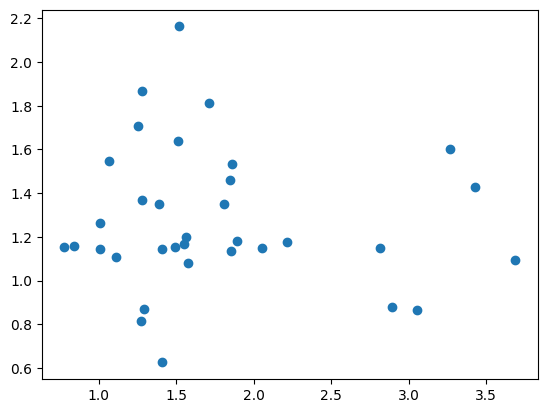

In [7]:
plt.scatter(cross_alignment_errors, within_errors)

In [88]:
for i in range(len(cross_alignment_errors)):
    if cross_alignment_errors[i] >= 2.5:
        subject, session, best_run, best_run_error = data_keys[i]

('sub-004', 'ses-13', 'run-1', np.float64(0.2641390114019835))
('sub-008', 'ses-07R', 'run-1', np.float64(0.169792258959403))
('sub-019', 'ses-13', 'run-1', np.float64(0.14902147758570977))
('sub-020', 'ses-07', 'run-5', np.float64(0.15157406619214506))
('sub-021', 'ses-07', 'run-1', np.float64(0.26302359188927354))
('sub-023', 'ses-13', 'run-5', np.float64(0.13936386635917336))
('sub-PBJ', 'ses-13', 'run-7', np.float64(0.14212623830129317))


In [191]:
subject = 'sub-021'
session = 'ses-07'

print(subject, session)
runs = subject_pool[subject][session]
root = f'{project_dir}/data/eyetracking/{subject}/{session}'
motion_params_root = '../../data/cross_alignment/merged_motion_params'
merged_motion_params_fname = f'{motion_params_root}/{subject}_{session}_task-mcHERDING_run-merged_bold_mcf.par'

if len(runs) >= 2 and os.path.exists(merged_motion_params_fname):
    calibration_errors = []
    for r in runs:
        run = f'run-{r}'
        key = (subject, session, task, run)
        calibration_error, _ = all_data[key]
        if calibration_error == None:
            calibration_error = 99.99
        calibration_errors.append(calibration_error)
    min_error_idx = np.argmin(calibration_errors)
    print('best calibration run:', runs[min_error_idx])
    best_run = f'run-{runs[min_error_idx]}'
    data_keys.append((subject, session, best_run, calibration_errors[min_error_idx]))

    run_pupils = {}
    run_motion_params = {}
    run_pupil_timestamps = {}
    run_pupil_confidences = {}

    concatenate_pupils = []
    concatenate_motion_params = []

    motion_params_root = '../../data/cross_alignment/merged_motion_params'
    merged_motion_params_fname = f'{motion_params_root}/{subject}_{session}_task-mcHERDING_run-merged_bold_mcf.par'
    merged_motion_params = get_mcflirt_motion_params(merged_motion_params_fname)

    for r in runs:
        np.random.seed(0)  # for reproducibility

        run = f'run-{r}'
        log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
        data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
        confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
        history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
        start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

        # log, data, confound, start
        pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
            log_fname,
            data_fname,
            start=start,
            duration=task_duration)
        if pupil_timestamps[-1] > ((task_duration - 1)) * 1000:  # valid run
            concatenate_pupils.append(pupil_data)

            motion_params = np.copy(merged_motion_params[510 * (r - 1):510 * r, :])

            motion_params_resample = np.zeros((len(pupil_data), motion_params.shape[1]))
            x = np.arange(0, len(motion_params))
            for i in range(motion_params.shape[1]):
                y = motion_params[:, i]
                f = interpolate.interp1d(x, y)
                xnew = np.linspace(0, len(motion_params) - 1, len(pupil_data))
                motion_params_resample[:, i] = f(xnew)
            concatenate_motion_params.append(motion_params_resample)

            run = f'run-{r}'
            run_pupils[run] = pupil_data
            run_pupil_timestamps[run] = pupil_timestamps
            run_pupil_confidences[run] = pupil_confidence
            run_motion_params[run] = motion_params_resample

    concatenate_pupils = np.vstack(concatenate_pupils)
    concatenate_motion_params = np.vstack(concatenate_motion_params)

    # fitting with best run
    motion_params =run_motion_params[best_run]
    pupil_data = run_pupils[best_run]
    pupil_timestamps = run_pupil_timestamps[best_run]
    pupil_confidence = run_pupil_confidences[best_run]

    X = np.hstack((run_motion_params[best_run], make_poly_regressors(len(motion_params), order=3)))

    coefs_ = []
    models = []
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        coefs_.append(reg.coef_)
        models.append(reg)
        dedrift_regressor[:, i] = reg.predict(X)
    pupils_corrected = pupil_data[:, :2] - dedrift_regressor
    pupils_corrected_mean = np.mean(pupils_corrected, axis=0)

    offset = calibration_onsets[0]
    calibration_pupils = []
    for i in np.arange(calibration_points[0]):
        start = (offset+i)*interval + calibration_offset_start
        end = (offset+i+1)*interval + calibration_offset_end
        log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
        calibration_pupils.append([np.nanmean(pupils_corrected[log_effective,0]),
                                  np.nanmean(pupils_corrected[log_effective,1])])
    calibration_pupils = np.array(calibration_pupils)

    calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                              calibration_order = calibration_order,
                                              repeat=True)
    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])

    # test with using other runs
    session_error = []
    for r in runs:
        test_run = f'run-{r}'
        key = (subject, session, task, test_run)
        calibration_error, validation_error = all_data[key]
        if validation_error != None:
            if np.all([validation_error <= 1.0, test_run != best_run]):
                print(test_run)
                motion_params = run_motion_params[test_run]
                pupil_data = run_pupils[test_run]
                pupil_timestamps = run_pupil_timestamps[test_run]
                pupil_confidence = run_pupil_confidences[test_run]

                X = motion_params
                dedrift_regressor = np.zeros((len(pupil_data), 2))
                for i in range(2):
                    #reg = models[i]
                    dedrift_regressor[:, i] = X @ coefs_[i][:6]
                pupils_corrected = pupil_data[:, :2] - dedrift_regressor
                #pupils_corrected -= np.mean(pupils_corrected, axis=0)
                pupils_corrected = polynomial_detrending(pupils_corrected, polynomial_order=3)
                #pupils_corrected -= np.mean(pupils_corrected, axis=0)
                #pupils_corrected += pupils_corrected_mean
                gaze_coordinates = calibrator.transform(pupils_corrected)

                MSE = []
                offset = calibration_onsets[1]
                for i in np.arange(calibration_points[1]):
                    ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                    ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                    start = (offset + i) * interval + calibration_offset_start
                    end = (offset + i + 1) * interval + calibration_offset_end
                    gaze_idx_start = np.min(np.where(pupil_timestamps >= start * 1000)[0])
                    gaze_idx_end = np.min(np.where(pupil_timestamps >= end * 1000)[0])
                    eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                    if np.any(~eye_closed):
                        data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                        data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                        MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                validation_error = np.nanmean(MSE) / px_per_deg
                session_error.append(validation_error)

    print(session_error)
    session_error = np.mean(session_error)
    print('Session across-map validation error:', session_error)

sub-021 ses-07
best calibration run: 1
run-2
run-5
run-6
[np.float64(2.0214116207296873), np.float64(3.800191340169688), np.float64(2.6197675487748904)]
Session across-map validation error: 2.8137901698914214


In [192]:
for r in runs:
    test_run = f'run-{r}'
    key = (subject, session, task, test_run)
    calibration_error, validation_error = all_data[key]
    print(key, calibration_error, validation_error)
    if validation_error != None:
        if np.all([validation_error <= 1.0, test_run != best_run]):
            print(test_run)

('sub-021', 'ses-07', 'task-mcHERDING', 'run-1') 0.26302359188927354 0.5339640937495043
('sub-021', 'ses-07', 'task-mcHERDING', 'run-2') 0.41610521269696205 0.32364381453526303
run-2
('sub-021', 'ses-07', 'task-mcHERDING', 'run-3') None None
('sub-021', 'ses-07', 'task-mcHERDING', 'run-4') 0.4678541711548023 1.1635720335360693
('sub-021', 'ses-07', 'task-mcHERDING', 'run-5') 2.51950296700346 0.7968552863176113
run-5
('sub-021', 'ses-07', 'task-mcHERDING', 'run-6') 0.3090095910717661 0.3079239820924757
run-6


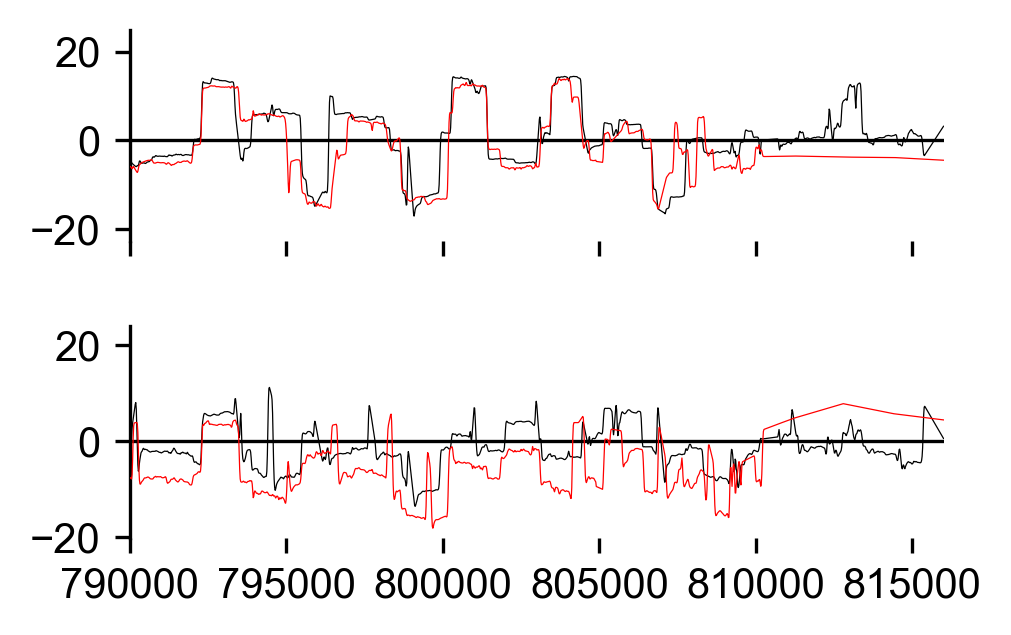

In [196]:
fig, axes = plt.subplots(2,1,figsize=(3.5,2.2), dpi=300, sharex=True)
for ax in axes:
    ax.axhline(y=0, color='k', linestyle='-', alpha=1.0, lw=0.8, zorder=3)
    ax.spines[['right', 'top','bottom']].set_visible(False)
plt.subplots_adjust(hspace=0.4)

motion_params =run_motion_params[best_run]
pupil_data = run_pupils[best_run]
pupil_timestamps = run_pupil_timestamps[best_run]
pupil_confidence = run_pupil_confidences[best_run]

X = np.hstack((run_motion_params[best_run], make_poly_regressors(len(motion_params), order=3)))

coefs_ = []
models = []
dedrift_regressor = np.zeros((len(pupil_data), 2))
for i in range(2):
    reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
    coefs_.append(reg.coef_)
    models.append(reg)
    dedrift_regressor[:, i] = reg.predict(X)
pupils_corrected = pupil_data[:, :2] - dedrift_regressor
axes[0].plot(pupil_timestamps, pupils_corrected[:,0], lw=0.3, c='k', zorder=100)
axes[1].plot(pupil_timestamps, pupils_corrected[:,1], lw=0.3, c='k', zorder=100)

test_run = 'run-5'
motion_params = run_motion_params[test_run]
pupil_data = run_pupils[test_run]
pupil_timestamps = run_pupil_timestamps[test_run]
pupil_confidence = run_pupil_confidences[test_run]

X = motion_params
dedrift_regressor = np.zeros((len(pupil_data), 2))
for i in range(2):
    #reg = models[i]
    dedrift_regressor[:, i] = X @ coefs_[i][:6]
pupils_corrected = pupil_data[:, :2] - dedrift_regressor
#pupils_corrected -= np.mean(pupils_corrected, axis=0)
pupils_corrected = polynomial_detrending(pupils_corrected, polynomial_order=3)
axes[0].plot(pupil_timestamps, pupils_corrected[:,0], lw=0.3, c='r', zorder=100)
axes[1].plot(pupil_timestamps, pupils_corrected[:,1], lw=0.3, c='r', zorder=100)
#axes[0].set_xlim(0, 40*1000)
axes[0].set_xlim(790*1000, 816*1000)

#axes[1].set_xticks([])
for ax in axes.flatten():
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

In [161]:
pupil_timestamps

array([1.66889000e+01, 3.33204000e+01, 5.00304000e+01, ...,
       8.15966399e+05, 8.15983117e+05, 8.15999760e+05], shape=(48913,))

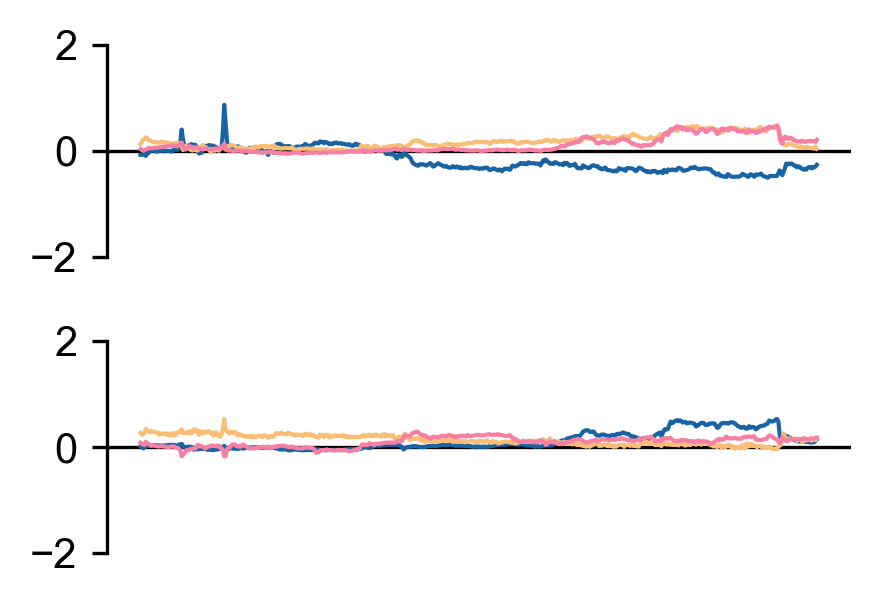

In [150]:
motion_params = run_motion_params['run-6']

fig, axes = plt.subplots(2,1,figsize=(3.2,2.2), dpi=300, sharex=True)

color_list = ["#1763a3","#f9bd75","#f77fa4","#1763a3","#f9bd75","#f77fa4"]
trans_offset = 2
for i in range(0,3):
    axes[1].plot(motion_params[:,i], lw=1, zorder=100, c=color_list[i])
    axes[1].set_ylim(-trans_offset, trans_offset)
    axes[1].set_yticks([-trans_offset,0,trans_offset])

rot_offset = 2
for i in range(3,6):
    axes[0].plot(np.rad2deg(motion_params[:,i]), lw=1, zorder=100, c=color_list[i])
    axes[0].set_ylim(-rot_offset, rot_offset)
    axes[0].set_yticks([-rot_offset,0,rot_offset])

TR = 1.6
xticks = np.array([0,240,480,720])
#axes[1].set_xticks(xticks/TR)
#axes[1].set_xticklabels([get_timeformat(s) for s in xticks])
axes[1].set_xticks([])
for ax in axes:
    # for i in [-2+0.02, -1, 0, 1, 2]:
    #     ax.axhline(y=i, color='k', linestyle='-', alpha=0.1, lw=0.2, zorder=2)
    # for xt in xticks:
    #     ax.axvline(x=xt/TR, color='k', linestyle='-', alpha=0.1, lw=0.2, zorder=2)
    ax.axhline(y=0, color='k', linestyle='-', alpha=1.0, lw=0.8, zorder=0)
    ax.spines[['right', 'top','bottom']].set_visible(False)
plt.subplots_adjust(hspace=0.4)

for ax in axes.flatten():
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

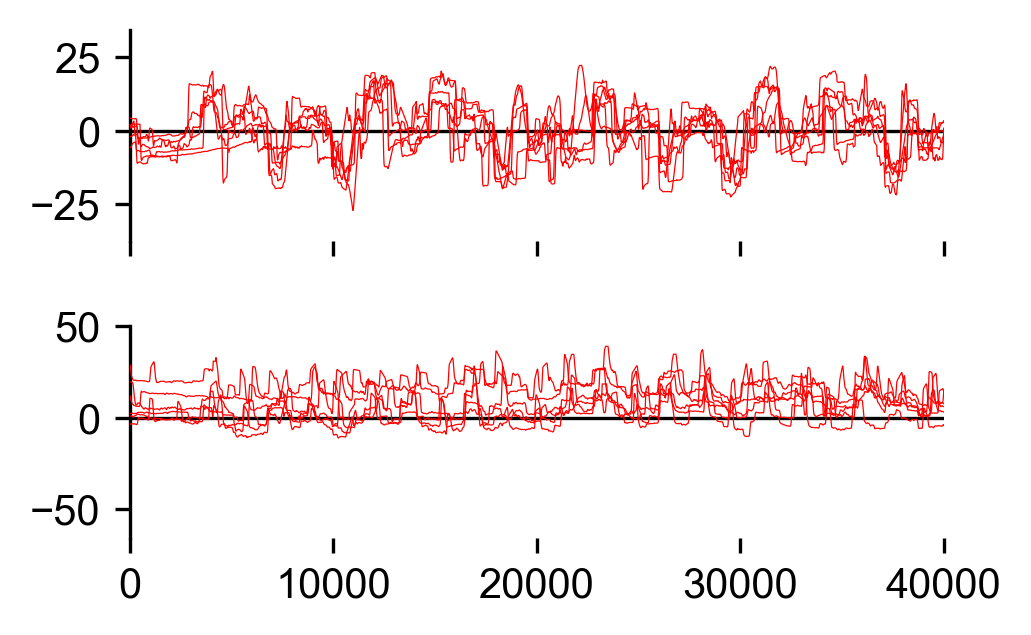

In [201]:
fig, axes = plt.subplots(2,1,figsize=(3.5,2.2), dpi=300, sharex=True)
for ax in axes:
    ax.axhline(y=0, color='k', linestyle='-', alpha=1.0, lw=0.8, zorder=3)
    ax.spines[['right', 'top','bottom']].set_visible(False)
plt.subplots_adjust(hspace=0.4)

subject = 'sub-017'
session = 'ses-07'

for r in [1,2,3,4,5,6]:
    run = f'run-{r}'
    root = f'{project_dir}/data/eyetracking/{subject}/{session}'
    log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
    data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
    history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
    start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

    # log, data, confound, start
    pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
        log_fname,
        data_fname,
        start=start,
        duration=task_duration)
    pupil_data -= np.mean(pupil_data, axis=0)
    axes[0].plot(pupil_timestamps, pupil_data[:,0], lw=0.3, c='r', zorder=100)
    axes[1].plot(pupil_timestamps, pupil_data[:,1], lw=0.3, c='r', zorder=100)
axes[0].set_xlim(0, 40*1000)
#axes[0].set_xlim(790*1000, 816*1000)

#axes[1].set_xticks([])
for ax in axes.flatten():
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

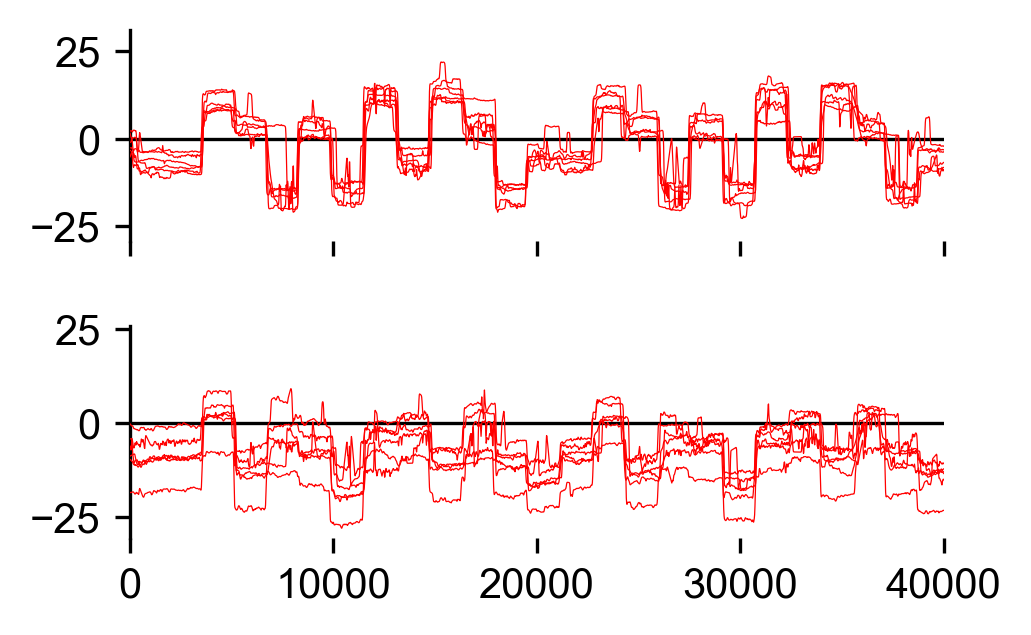

In [202]:
fig, axes = plt.subplots(2,1,figsize=(3.5,2.2), dpi=300, sharex=True)
for ax in axes:
    ax.axhline(y=0, color='k', linestyle='-', alpha=1.0, lw=0.8, zorder=3)
    ax.spines[['right', 'top','bottom']].set_visible(False)
plt.subplots_adjust(hspace=0.4)

subject = 'sub-020'
session = 'ses-07'

for r in [1,2,3,4,5,6]:
    run = f'run-{r}'
    root = f'{project_dir}/data/eyetracking/{subject}/{session}'
    log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
    data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
    history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
    start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

    # log, data, confound, start
    pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
        log_fname,
        data_fname,
        start=start,
        duration=task_duration)
    pupil_data -= np.mean(pupil_data, axis=0)
    axes[0].plot(pupil_timestamps, pupil_data[:,0], lw=0.3, c='r', zorder=100)
    axes[1].plot(pupil_timestamps, pupil_data[:,1], lw=0.3, c='r', zorder=100)
axes[0].set_xlim(0, 40*1000)
#axes[0].set_xlim(790*1000, 816*1000)

#axes[1].set_xticks([])
for ax in axes.flatten():
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")